In [1]:
!nvidia-smi
!pip install fastai --upgrade -q
!pip install timm
!pip install nbdev
import torch
import timm
from fastai.vision.all import *

Tue May 25 12:33:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#view in colab here : https://colab.research.google.com/drive/1Fs2qgxZVijH1EXNKuh2P6ARHYZC7BQh2?usp=sharing

In [2]:
source = untar_data(URLs.DOGS)
print(source)

/root/.fastai/data/dogscats


In [3]:
data = DataBlock(
   blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
   item_tfms=RandomResizedCrop(224, min_scale=0.5),
   batch_tfms=aug_transforms(
       flip_vert=True,
       max_rotate=360,
       max_lighting=0.2, 
       max_warp=0.2,
       xtra_tfms=RandomErasing(p=1.0),
       p_affine=1.0, 
       p_lighting=1.0)
)

dls = data.dataloaders(source=source, bs=64 , val_bs=16, device='cuda',  verbose=True)

Found 37524 items
2 datasets of sizes 23016,2008
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.5, 'ratio': (0.75, 1.3333333333333333), 'resamples': (2, 0), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> RandomErasing -- {'p': 1.0, 'sl': 0.0, 'sh': 0.3, 'min_aspect': 0.3, 'max_count': 1}


In [4]:
doc(DataBlock)

In [5]:
x, y = dls.one_batch()
print(x.shape)
print(y.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


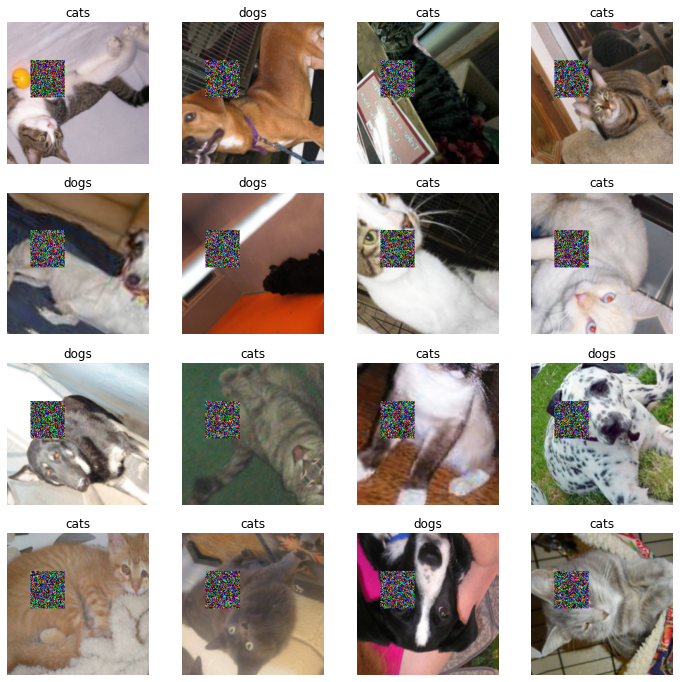

In [6]:
dls.show_batch(max_n=16)

In [7]:
n_classes = 2
model = timm.create_model("vit_base_patch16_224", pretrained=True)
outputs_attrs = n_classes
num_inputs = model.head.in_features
last_layer = nn.Linear(num_inputs, outputs_attrs)
model.head = last_layer
model = model.cuda()

In [8]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [9]:
learn = Learner(dls, model, opt_func=Adam, metrics=accuracy)
learn.to_fp16()
learn.summary()

VisionTransformer (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 768 x 14 x 14  
Conv2d                                    590592     True      
Identity                                                       
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     64 x 197 x 2304     
Linear                                    1771776    True      
Dropout                                                        
Linear                                    590592     True      
Dropout                                                        
Identity                                                       
LayerNorm                                 1536       True      
____________________________________________________________________________
                     6

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=9.120108734350652e-05)

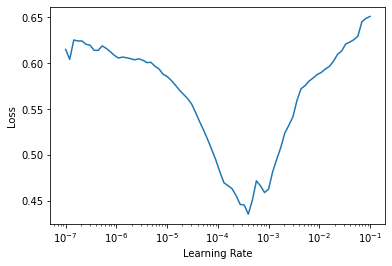

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.112382,0.030831,0.989044,47:37
1,0.088517,0.025624,0.991036,47:29
2,0.072336,0.017130,0.993526,47:12


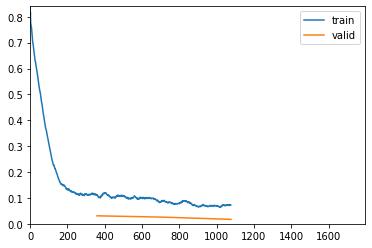

epoch,train_loss,valid_loss,accuracy,time
0,0.112382,0.030831,0.989044,47:37
1,0.088517,0.025624,0.991036,47:29
2,0.072336,0.017130,0.993526,47:12
3,0.043924,0.016224,0.995020,47:11
4,0.035972,0.015584,0.994024,47:02


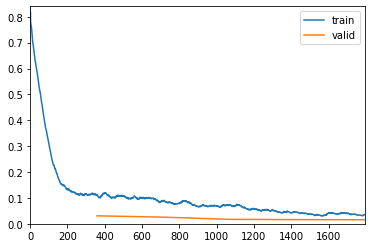

In [14]:
learn.fit_one_cycle(n_epoch=5, lr_max=slice(1e-5,1e-4), cbs=ShowGraphCallback)

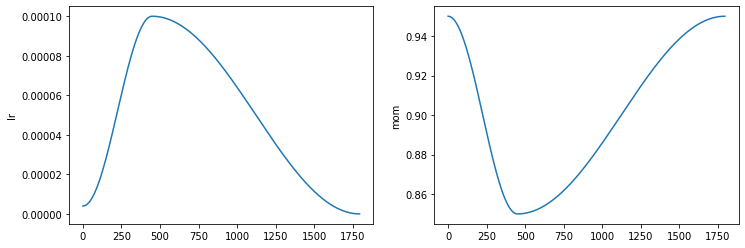

In [15]:
learn.recorder.plot_sched()

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

              precision    recall  f1-score   support

        cats       1.00      0.99      0.99      1004
        dogs       0.99      1.00      0.99      1004

    accuracy                           0.99      2008
   macro avg       0.99      0.99      0.99      2008
weighted avg       0.99      0.99      0.99      2008



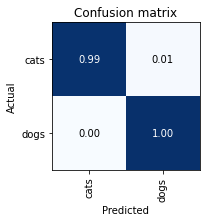

In [22]:
interp.plot_confusion_matrix(normalize=True, figsize=(3,3))

In [23]:
interp.plot_top_losses(60)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
import torch.jit
dummy_inp = torch.randn([1,3,224,224]).cuda()
model = learn.model.eval().cuda()
traced_model = torch.jit.trace(model, dummy_inp)

/usr/local/lib/python3.7/dist-packages/timm/models/layers/patch_embed.py:32: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H == self.img_size[0] and W == self.img_size[1], \


In [24]:
import time
st = time.time()
output = traced_model(dummy_inp)
print(time.time()-st)
print(output)

0.8533773422241211
tensor([[0.4573, 0.0039]], device='cuda:0', grad_fn=<AddBackward0>)


In [26]:
learn.save('/content/drive/MyDrive/Colab Notebooks/vit_model')

Path('/content/drive/MyDrive/Colab Notebooks/vit_model.pth')

In [ ]:
#view model here : https://drive.google.com/file/d/1d7qB7z-obBpEJnc41rXRSzaUzGYqIB8u/view?usp=sharing